# Definition

In [1]:
import os
import numpy as np
import ga_PD_adaptive as ga
from joblib import load
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [2]:


# Configuration dictionaries
config_pc_remote = {
    "model_P_D": r'D:\Krishna\ai-power-converter\machine-learning\split_model\model_1_256_pd.h5',
    "model_P_l_C": r'D:\Krishna\ai-power-converter\machine-learning\split_model\model_2_128_Plc.h5',
    "model_P_l_s1": r'D:\Krishna\ai-power-converter\machine-learning\split_model\new\model_2_256_Pls1_Pls2_scaler_12_5.h5',
    "model_P_l_L_Cu": r'D:\Krishna\ai-power-converter\machine-learning\split_model\model_4_256_Pllcu.h5',
    "model_delta_voltage": r'D:\Krishna\ai-power-converter\machine-learning\split_model\new\model_4_256_delta_voltage_scaler_11_5.h5',
    "model_delta_current": r'D:\Krishna\ai-power-converter\machine-learning\split_model\new\model_2_256_delta_current_scaler_11_5.h5',
    "model_voltage": r'D:\Krishna\ai-power-converter\machine-learning\model_3_64_voltage_scaler_14_5.h5',
    "csv_file_capacitance": r'D:\Krishna\ai-power-converter-1\dataset\capacitor_lookup_table.csv',
    "csv_file_inductance": r'D:\Krishna\ai-power-converter-1\dataset\inductor_lookup_table.csv',
    "df_data": r'D:\Krishna\ai-power-converter-1\simulation_results_new_20_20_20_20.csv',
    "df_data_1": r'D:\Krishna\ai-power-converter-1\simulation_results_newest_15_4.csv'
}



config_laptop = {
    "model_P_D": r'E:\ai-power-converter\machine-learning\split_model\model_1_256_pd.h5',
    "model_P_l_C": r'E:\ai-power-converter\machine-learning\split_model\model_2_128_Plc.h5',
    "model_P_l_s1": r'E:\ai-power-converter\machine-learning\split_model\new\model_2_256_Pls1_Pls2_scaler_12_5.h5',
    "model_P_l_L_Cu": r'E:\ai-power-converter\machine-learning\split_model\model_4_256_Pllcu.h5',
    "model_delta_voltage": r'E:\ai-power-converter\machine-learning\split_model\new\model_4_256_delta_voltage_scaler_11_5.h5',
    "model_delta_current": r'E:\ai-power-converter\machine-learning\split_model\new\model_2_256_delta_current_scaler_11_5.h5',
    "model_voltage": r'E:\ai-power-converter\machine-learning\model_3_64_voltage_scaler_14_5.h5',
    "csv_file_capacitance": r'E:\ai-power-converter\dataset\capacitor_lookup_table.csv',
    "csv_file_inductance": r'E:\ai-power-converter\dataset\inductor_lookup_table.csv',
    "df_data": r'E:\ai-power-converter\simulation_results_new_20_20_20_20.csv',
    "df_data_1": r'E:\ai-power-converter\simulation_results_newest_15_4.csv'
}

# df_data = pd.read_csv(r"D:\Krishna\ai-power-converter-1\simulation_results_new_20_20_20_20.csv")
# df_data_1 = pd.read_csv(r"D:\Krishna\ai-power-converter-1\simulation_results_newest_15_4.csv")

# Choose which configuration to use
config = config_laptop  # or config_pc2 depending on the PC

# Load models
model_P_D = tf.keras.models.load_model(config["model_P_D"])
model_P_l_C = tf.keras.models.load_model(config["model_P_l_C"])
model_P_l_s1 = tf.keras.models.load_model(config["model_P_l_s1"])
model_P_l_L_Cu = tf.keras.models.load_model(config["model_P_l_L_Cu"])
model_delta_voltage = tf.keras.models.load_model(config["model_delta_voltage"])
model_delta_current = tf.keras.models.load_model(config["model_delta_current"])
model_voltage = tf.keras.models.load_model(config["model_voltage"])

# Load CSV files
csv_file_capacitance = config["csv_file_capacitance"]
csv_file_inductance = config["csv_file_inductance"]

df_data = pd.read_csv(config["df_data"])
df_data_1 = pd.read_csv(config["df_data_1"])


# Define constraint values
V_out = 12
Vol_lim = 7e-6
Delta_Vo_percent_lim = 1
Delta_IL_percent_lim = 10
Voltage_percent_lim = 0.2

In [3]:


# Genetic algorithm parameters
sol_per_pop = 10
num_parents_mating = 5
pop_size = (sol_per_pop, 4)  # We have 3 variables: fs, L, C
num_generations = 3

# Generate initial population
L_range = (30e-6, 2000e-6)  # Range for L
C_range = (30e-6, 200e-6)   # Range for C
fsw_range = (20e3, 200e3)    # Range for fsw
t_dt_range = (0.178e-6, 1e-6) # Range for dead time

num_values = sol_per_pop

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

# Define mutation ranges for each parameter
mutation_ranges = [(30e-6, 100e-6), (20e-6, 100e-6), (10, 1000), (0.001e-6, 0.1e-6)]

# # Create arrays of discrete L, C, and fsw values within the specified ranges
L_values = np.linspace(L_range[0], L_range[1], num=num_values)
C_values = np.linspace(C_range[0], C_range[1], num=num_values)
t_dt_values = np.linspace(t_dt_range[0], t_dt_range[1], num=num_values)

# Round the values to the desired number of decimal places
L_values = np.around(L_values, decimals=6)
C_values = np.around(C_values, decimals=6)
t_dt_values = np.around(t_dt_values, decimals=9)

fsw_values = np.linspace(fsw_range[0], fsw_range[1], num=num_values, dtype=int)

initial_population = np.column_stack((L_values, C_values, fsw_values, t_dt_values))

# Function

## Scaling

In [4]:
def scale_input_values(input_values):

    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array

    # Scale L
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)

    # Scale C
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)

    # Scale fsw
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)

    input_values_scaled[3] = (input_values[3] - t_dt_min) / (t_dt_max - t_dt_min)
    # Make predictions using the model

    # Reshape the input data to match the expected shape of the model
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    return input_values_reshaped


def inverse_scale_input_values(scaled_input_values):
    # Reshape the scaled input values to the original shape
    input_values_scaled = scaled_input_values.reshape(-1)

    # Reverse scaling for L
    input_values_scaled[0] = input_values_scaled[0] * (L_max - L_min) + L_min

    # Reverse scaling for C
    input_values_scaled[1] = input_values_scaled[1] * (C_max - C_min) + C_min

    # Reverse scaling for fsw
    input_values_scaled[2] = input_values_scaled[2] * (fsw_max - fsw_min) + fsw_min

    # Reverse scaling for t_dt
    input_values_scaled[3] = input_values_scaled[3] * (t_dt_max - t_dt_min) + t_dt_min

    # Reshape the input data to match the original shape
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    return input_values_reshaped


In [5]:
# Generate some sample input data
input_values = [1500e-6, 700e-6, 120e3, 0.6e-6]

# Scale the input data
scaled_input = scale_input_values(input_values)
print("Scaled Input Values:")
print(scaled_input)

# Inverse scale the scaled input data
inverse_scaled_input = inverse_scale_input_values(scaled_input)
print("\nInverse Scaled Input Values:")
print(inverse_scaled_input)

# Compare with original input data
print("\nOriginal Input Values:")
print(input_values)


Scaled Input Values:
[[0.74619289 0.69387755 0.55555556 0.513382  ]]

Inverse Scaled Input Values:
[[1.5e-03 7.0e-04 1.2e+05 6.0e-07]]

Original Input Values:
[0.0015, 0.0007, 120000.0, 6e-07]


In [6]:
def custom_scaling_minmax(X):
    scaled_features = []  # List to store scaled features
    
    # Define custom minimum and maximum values for each feature
    feature_ranges = {
        'L': (30e-6, 2000e-6),
        'C': (20e-6, 1000e-6),
        'fsw': (20e3, 200e3),
        't_dt': (0.178e-6, 1e-6)
    }

    for i, feature_name in enumerate(['L', 'C', 'fsw', 't_dt']):
        # Extract min and max values for the current feature
        feature_min, feature_max = feature_ranges[feature_name]
        
        # Define MinMaxScaler with custom input range
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit([[feature_min], [feature_max]])
        
        # Transform the current feature using the scaler
        # scaled_feature = scaler.transform(X[:, i].reshape(-1, 1))
        
        scaled_feature = scaler.transform(X.reshape(-1, 1))
        # Append the scaled feature to the list
        scaled_features.append(scaled_feature)
    
    # Combine the scaled features into a single array
    X_scaled = np.hstack(scaled_features)
    
    return X_scaled

In [7]:


y_delta_current_1 = df_data[["delta_current"]].values  # Adjust column names as per your dataset
y_delta_voltage_1 = df_data[["delta_voltage"]].values
y_Pl_s1_1 = df_data[["Pl_s1"]].values
y_voltage_1 = df_data_1[["voltage"]].values  # Adjust column names as per your dataset


scaler_y_delta_current = MinMaxScaler(feature_range=(0, 1))
scaler_y_delta_voltage = MinMaxScaler(feature_range=(0, 1))
scaler_y_Pl_s1 = MinMaxScaler(feature_range=(0, 1))
scaler_voltage = MinMaxScaler(feature_range=(0, 1))


# Fit the scaler to your target variable and transform it
y_scaled_delta_current_1 = scaler_y_delta_current.fit_transform(y_delta_current_1)
y_scaled_delta_voltage_1 = scaler_y_delta_voltage.fit_transform(y_delta_voltage_1)
y_scaled_Pl_s1_1 = scaler_y_Pl_s1.fit_transform(y_Pl_s1_1)
y_scaled_voltage_1 = scaler_voltage.fit_transform(y_voltage_1)

## Calculate Fitness

In [8]:

# def calculate_fitness(individual):

#     input_values_scaled = scale_input_values(individual)

#     # prediction = model.predict(input_values_scaled, verbose=0)
    
#     # Extract predictions from the model output
#     P_l_s1_ori = model_P_l_s1.predict(input_values_scaled, verbose=0)    
#     P_l_s1 = scaler_y_Pl_s1.inverse_transform(P_l_s1_ori)
    
#     P_l_s2 = P_l_s1
#     P_l_C = model_P_l_C.predict(input_values_scaled, verbose=0)
#     P_l_L_Cu = model_P_l_L_Cu.predict(input_values_scaled, verbose=0)
#     P_D = model_P_D.predict(input_values_scaled, verbose=0)

#     # P_l_s1 = prediction[0][2]
#     # P_l_s2 = prediction[0][3]
#     # P_l_C = prediction[0][4]
#     # P_l_L_Cu = prediction[0][5]
#     # P_D = prediction[0][6]
    
#     # Calculate the objective function value based on the given equation
#     objective_value = P_l_s1 + P_l_s2 + P_l_L_Cu + P_l_C + P_D
    
#     return objective_value

def calculate_fitness(individual):
    input_values_scaled = scale_input_values(individual)

    # Make predictions using the models
    P_l_s1_ori = model_P_l_s1.predict(input_values_scaled, verbose=0)    
    P_l_s1 = scaler_y_Pl_s1.inverse_transform(P_l_s1_ori)
    
    P_l_s2 = P_l_s1
    P_l_C = model_P_l_C.predict(input_values_scaled, verbose=0)
    P_l_L_Cu = model_P_l_L_Cu.predict(input_values_scaled, verbose=0)
    P_D = model_P_D.predict(input_values_scaled, verbose=0)

    # Calculate the objective function value based on the given equation
    objective_value = P_l_s1 + P_l_s2 + P_l_L_Cu + P_l_C + P_D

    # Add a penalty if the individual does not meet the constraints
    penalty = 0
    if not check_constraints(individual):
        penalty = 1e6  # Large penalty for constraint violation

    return objective_value + penalty


## Search Volume

### Capacitance

In [9]:
def search_volume_capacitance(capacitance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        capacitance_values = []
        volume_values = []
        for row in reader:
            capacitance_values.append(float(row['Capacitance']))
            volume_values.append(float(row['Total Volume']))
        
        # Find the index of the nearest capacitance value
        nearest_idx = np.abs(np.array(capacitance_values) - capacitance).argmin()
        nearest_capacitance = capacitance_values[nearest_idx]
        nearest_volume = volume_values[nearest_idx]
        
        return nearest_capacitance, nearest_volume

### Inductance

In [10]:

def search_volume_inductance(inductance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        inductance_values = []
        volume_values = []
        for row in reader:
            inductance_values.append(float(row['Inductance']))
            volume_values.append(float(row['Volume']))
        
        # Find the index of the nearest inductance value
        nearest_idx = np.abs(np.array(inductance_values) - inductance).argmin()
        nearest_inductance = inductance_values[nearest_idx]
        nearest_volume = volume_values[nearest_idx]
        
        return nearest_inductance, nearest_volume


## Check Constraints

In [11]:
feature_ranges = {
    'L': (30e-6, 2000e-6),  # Custom range for feature L
    'C': (20e-6, 1000e-6),   # Custom range for feature C
    'fsw': (20e3, 200e3),    # Custom range for feature fsw
    't_dt': (0.178e-6, 1e-6) # Custom range for feature t_dt
}



# Define the constraints function
def check_constraints(individual):
    L = individual[0]
    C = individual[1]
    fs = individual[2]
    t_dt = individual[3]
    
    # Define the constraint values
    nearest_C, Vol_C  = search_volume_capacitance(C, csv_file_capacitance) # Define Vol_L based on your problem-specific requirements
    nearest_L, Vol_L  = search_volume_inductance(L, csv_file_inductance)

    # Prepare input values for prediction

    input_values = np.array([L, C, fs, t_dt])
    # Apply Min-Max normalization separately for each input feature
    
    # print("input_values", input_values)
    input_values_scaled = scale_input_values(input_values)
    # input_values_scaled = scaler_y_new_20_20_20_20.transform(input_values)
    # print("scaled", input_values_scaled)
    # prediction = model.predict(input_values_scaled, verbose = 0)

    # Extract predictions from the model output
    Delta_IL_percent_ori = model_delta_current.predict(input_values_scaled, verbose = 0)
    Delta_Vo_percent_ori = model_delta_voltage.predict(input_values_scaled, verbose = 0)

    Voltage_ori = model_voltage.predict(input_values_scaled, verbose = 0)
    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    # Voltage = 12
    # print("Voltage:", Voltage)

    
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    # print("Shape \n")
    # print(Delta_IL_percent_ori.shape)
    # print(Delta_Vo_percent_ori.shape)
    # scaler_y_new_loaded = load(r'E:\ai-power-converter\machine-learning\scaler_y_new_20_20_20_20.joblib')
    
    # # Fit the scaler with the training data
    # scaler_y_new_loaded.fit([[feature_min], [feature_max]])
    # Inverse transform the predictions
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent_ori)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent_ori)

    # print("delta_IL inverse",Delta_IL_percent)
    # print("delta_Vo inverse",Delta_Vo_percent)

    # Delta_IL_percent = inverse_scale_input_values(Delta_IL_percent_ori)
    # Delta_Vo_percent = inverse_scale_input_values(Delta_Vo_percent_ori)

    # Define the acceptable voltage range
    acceptable_voltage_range = (V_out - Voltage_percent_lim * V_out, V_out + Voltage_percent_lim * V_out)

    # Check if Voltage_ori is within the acceptable voltage range


    # Check if constraints are satisfied
    constraint1 = Vol_C + Vol_L  <= Vol_lim
    constraint2 = Delta_Vo_percent <= Delta_Vo_percent_lim
    constraint3 = Delta_IL_percent <= Delta_IL_percent_lim
    constraint4 = (Voltage >= acceptable_voltage_range[0]) and (Voltage <= acceptable_voltage_range[1])
    
    # print("Constraint 1", constraint1)
    # print("Constraint 2", constraint2)
    # print("Constraint 3", constraint3)
    # print("Constraint 4", constraint4)

    # print("Constraint:", constraint1 and constraint2 and constraint3 and constraint4)

    # return constraint1 and constraint2 and constraint3
    return constraint1 and constraint2 and constraint3 and constraint4 

In [12]:
feature_ranges = {
    'L': (30e-6, 2000e-6),  # Custom range for feature L
    'C': (20e-6, 1000e-6),   # Custom range for feature C
    'fsw': (20e3, 200e3),    # Custom range for feature fsw
    't_dt': (0.178e-6, 1e-6) # Custom range for feature t_dt
}



# Define the constraints function
def check_constraints_2(individual):
    L = individual[0]
    C = individual[1]
    fs = individual[2]
    t_dt = individual[3]
    
    # Define the constraint values
    nearest_C, Vol_C  = search_volume_capacitance(C, csv_file_capacitance) # Define Vol_L based on your problem-specific requirements
    nearest_L, Vol_L  = search_volume_inductance(L, csv_file_inductance)

    # Prepare input values for prediction

    input_values = np.array([L, C, fs, t_dt])
    # Apply Min-Max normalization separately for each input feature
    
    # print("input_values", input_values)
    input_values_scaled = scale_input_values(input_values)
    # input_values_scaled = scaler_y_new_20_20_20_20.transform(input_values)
    # print("scaled", input_values_scaled)
    # prediction = model.predict(input_values_scaled, verbose = 0)

    # Extract predictions from the model output
    Delta_IL_percent_ori = model_delta_current.predict(input_values_scaled, verbose = 0)
    Delta_Vo_percent_ori = model_delta_voltage.predict(input_values_scaled, verbose = 0)

    Voltage_ori = model_voltage.predict(input_values_scaled, verbose = 0)
    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    # Voltage = 12
    # print("Voltage:", Voltage)

    
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    # print("Shape \n")
    # print(Delta_IL_percent_ori.shape)
    # print(Delta_Vo_percent_ori.shape)
    # scaler_y_new_loaded = load(r'E:\ai-power-converter\machine-learning\scaler_y_new_20_20_20_20.joblib')
    
    # # Fit the scaler with the training data
    # scaler_y_new_loaded.fit([[feature_min], [feature_max]])
    # Inverse transform the predictions
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent_ori)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent_ori)

    # print("delta_IL inverse",Delta_IL_percent)
    # print("delta_Vo inverse",Delta_Vo_percent)

    # Delta_IL_percent = inverse_scale_input_values(Delta_IL_percent_ori)
    # Delta_Vo_percent = inverse_scale_input_values(Delta_Vo_percent_ori)

    # Define the acceptable voltage range
    acceptable_voltage_range = (V_out - Voltage_percent_lim * V_out, V_out + Voltage_percent_lim * V_out)

    # Check if Voltage_ori is within the acceptable voltage range


    # Check if constraints are satisfied
    constraint1 = Vol_C + Vol_L  <= Vol_lim
    constraint2 = Delta_Vo_percent <= Delta_Vo_percent_lim
    constraint3 = Delta_IL_percent <= Delta_IL_percent_lim
    constraint4 = (Voltage >= acceptable_voltage_range[0]) and (Voltage <= acceptable_voltage_range[1])
    
    # print("Constraint 1", constraint1)
    # print("Constraint 2", constraint2)
    # print("Constraint 3", constraint3)
    # print("Constraint 4", constraint4)

    # print("Constraint:", constraint1 and constraint2 and constraint3 and constraint4)

    # return constraint1 and constraint2 and constraint3
    degree_of_satisfaction = 0
    if not constraint1:
        degree_of_satisfaction += 1
    if not constraint2:
        degree_of_satisfaction += 1
    if not constraint3:
        degree_of_satisfaction += 1
    if not constraint4:
        degree_of_satisfaction += 1
    return degree_of_satisfaction 

# Genetic Algorithm

## With inner GA

In [13]:
# Define inner GA functions
def inner_ga_create_population(pop_size, L_range, C_range, fsw_range, t_dt_range):
    population = []
    for _ in range(pop_size):
        L_values_all = np.arange(L_range[0], L_range[1] + 1e-6, 1e-6)
        C_values_all = np.arange(C_range[0], C_range[1] + 1e-6, 1e-6)
        t_dt_values_all = np.arange(t_dt_range[0], t_dt_range[1] + 0.001e-6, 0.001e-6)

        # Generate new random values for L, C, fsw, and t_dt
        L = np.random.choice(L_values_all, 1, replace=False)[0]
        C = np.random.choice(C_values_all, 1, replace=False)[0]
        fsw = np.random.randint(fsw_range[0], fsw_range[1] + 1)
        t_dt = np.random.choice(t_dt_values_all, 1, replace=False)[0]

        population.append([L, C, fsw, t_dt])
    return np.array(population)


def inner_ga_fitness(population):
    fitness_values = []
    for individual in population:
        fitness_value = check_constraints_2(individual)
        # if not check_constraints(individual):
        #     fitness_value += 1  # Increment fitness for each violated constraint
        fitness_values.append(fitness_value)
    return np.array(fitness_values)

def inner_ga_select_parents(population, fitness, num_parents):
    # Ensure fitness values are floats
    fitness = fitness.astype(float)
    # Select the best individuals as parents
    parents = np.empty((num_parents, population.shape[1]))
    for parent_num in range(num_parents):
        min_fitness_idx = np.argmin(fitness)
        parents[parent_num, :] = population[min_fitness_idx, :]
        fitness[min_fitness_idx] = float('inf')  # Set to infinity to exclude in next selection
    return parents


def inner_ga_crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1] / 2)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def inner_ga_mutation(offspring, L_range, C_range, fsw_range, t_dt_range):
    for idx in range(offspring.shape[0]):
        mutation_idx = np.random.randint(offspring.shape[1])
        if mutation_idx == 0:
            offspring[idx, mutation_idx] = np.random.uniform(L_range[0], L_range[1])
        elif mutation_idx == 1:
            offspring[idx, mutation_idx] = np.random.uniform(C_range[0], C_range[1])
        elif mutation_idx == 2:
            offspring[idx, mutation_idx] = np.random.randint(fsw_range[0], fsw_range[1] + 1)
        else:
            offspring[idx, mutation_idx] = np.random.uniform(t_dt_range[0], t_dt_range[1])
    return offspring

Generation :  0
Population [[1.7010e-03 6.6000e-05 2.4383e+04 7.9120e-07]
 [1.8140e-03 3.0000e-05 3.5116e+04 7.2000e-07]
 [2.0000e-03 3.0000e-05 2.0000e+04 1.0000e-06]
 [1.9470e-03 3.0000e-05 2.0000e+04 9.4520e-07]
 [1.8820e-03 3.0000e-05 2.0000e+04 8.8600e-07]
 [1.4820e-03 4.5000e-05 7.6000e+04 2.7820e-07]
 [1.9320e-03 6.7000e-05 5.3131e+04 2.8600e-07]
 [7.2400e-04 1.7900e-04 2.0000e+04 1.0000e-06]
 [1.0670e-03 4.6000e-05 2.0000e+04 1.0000e-06]
 [1.7820e-03 3.0000e-05 2.0000e+04 1.7800e-07]]
Best result: 5.35985
Best solution index: 0
Best solution: [1.7010e-03 6.6000e-05 2.4383e+04 7.9120e-07]
Best solutions array: [array([1.7010e-03, 6.6000e-05, 2.4383e+04, 7.9120e-07])]
Best fitness: [5.35985]
Best fitnesses: [5.35985]
check constraints [[ True]]
check constraints [[ True]]
check constraints [[ True]]
check constraints [[ True]]
check constraints [[ True]]
check constraints [[ True]]
check constraints [[ True]]
check constraints [[False]]
inner population [[6.40000e-05 1.58000e-04 

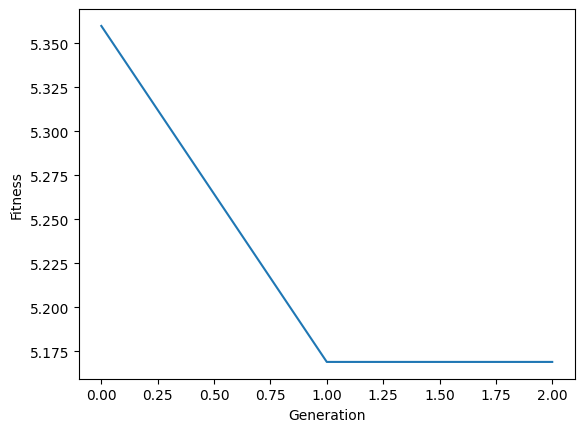

In [28]:
# Main GA Loop
best_outputs = []
best_solutions = []
best_fitnesses = []
new_population = initial_population


sol_per_pop = 10
num_parents_mating = 5
pop_size = (sol_per_pop, 4)  # We have 3 variables: fs, L, C
num_generations = 3

inner_sol_per_pop = 8
inner_pop_size = 8#(sol_per_pop, 4) 
inner_num_parents_mating = 4

# Generate initial population
L_range = (30e-6, 2000e-6)  # Range for L
C_range = (30e-6, 200e-6)   # Range for C
fsw_range = (20e3, 200e3)    # Range for fsw
t_dt_range = (0.178e-6, 1e-6) # Range for dead time

mutation_ranges = [
    (L_range[0], L_range[1]),    # Mutation range for L
    (C_range[0], C_range[1]),    # Mutation range for C
    (fsw_range[0], fsw_range[1]),# Mutation range for fsw
    (t_dt_range[0], t_dt_range[1]) # Mutation range for t_dt
]

for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measuring the fitness of each chromosome in the population.
    fitness_values = []
    delta_IL_percent_values = []
    delta_Vo_percent_values = []
    for individual in new_population:
        fitness_value = calculate_fitness(individual)
        # print('fitness value', fitness_value)
        fitness_values.append(fitness_value)

    fitness = np.array(fitness_values)
    # print('cek fitness', fitness)

    print("Population", new_population)
    best_outputs.append(np.min(fitness))
    print("Best result:", np.min(fitness))

    # Find the index of the best solution in this generation
    best_solution_idx = np.argmin(fitness)
    print("Best solution index:", best_solution_idx)

    # Retrieve the best solution from the population
    best_solution = new_population[best_solution_idx].copy()  # Copy the best solution
    print("Best solution:", best_solution)

    # Append the current best solution to the list of best solutions
    best_solutions.append(best_solution.copy())  # Append a copy of the best solution
    print("Best solutions array:", best_solutions)

    # Append the corresponding fitness value to the list of best fitnesses
    best_fitness = fitness[best_solution_idx][0]

    best_fitnesses.append(best_fitness[0])
    print("Best fitness:", best_fitness)
    print("Best fitnesses:", best_fitnesses)



    # Check and enforce constraints using inner GA
    for i in range(sol_per_pop):
        # print("I'm here")
        print("check constraints", check_constraints(new_population[i]) )
        
        if not check_constraints(new_population[i]):
            inner_population = inner_ga_create_population(inner_pop_size, L_range, C_range, fsw_range, t_dt_range)
            print("inner population", inner_population)
            found_valid_solution = False

            loop_counter = 0
            previous_crossover_point = None

            crossover_point = np.random.randint(1, 4)
            print("first crossover point", crossover_point)
            
            while not found_valid_solution:
                inner_fitness_values = inner_ga_fitness(inner_population)
                print("inner fitness", inner_fitness_values)
                if 0 in inner_fitness_values:
                    valid_solution_idx = np.argmin(inner_fitness_values)
                    new_population[i] = inner_population[valid_solution_idx]
                    
                    found_valid_solution = True
                    print("Found valid solution")
                else:
                    inner_parents = inner_ga_select_parents(inner_population, inner_fitness_values, inner_num_parents_mating)
                    print("innner parents", inner_parents)
                    # inner_offspring_crossover = ga.crossover_inner(inner_parents, offspring_size=(inner_pop_size - inner_parents.shape[0], 4), crossover_point=crossover_point)
                    inner_offspring_crossover = ga.crossover(inner_parents, offspring_size=(inner_parents.shape[0], 4))
                    print("inner crossover", inner_offspring_crossover)
                    offspring_size=(inner_pop_size - inner_parents.shape[0], 4)
                    print("inner offspring size", offspring_size)
                    inner_offspring_mutation = ga.mutation_inner(inner_offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, t_dt_range, num_mutations=3)
                    print("inner mutation", inner_offspring_mutation)
                    inner_population[:inner_parents.shape[0], :] = inner_parents
                    inner_population[inner_parents.shape[0]:, :] = inner_offspring_mutation
                    print("still finding")

                    # Increment the loop counter
                    loop_counter += 1

                    # Change the crossover point every 3 iterations
                    if loop_counter % 3 == 0:
                        while True:
                            new_crossover_point = np.random.randint(1, 4)  # Adjust range as needed
                            if new_crossover_point != crossover_point:
                                crossover_point = new_crossover_point
                                break
                        print(f"Changed crossover point to {crossover_point}")

    parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)
    print("Outer parents", parents)
    offspring_crossover = ga.crossover_adaptive(parents, offspring_size=(pop_size[0]-parents.shape[0], 4), best_fitnesses=best_fitnesses)
    print("Outer crossover", offspring_crossover)
    offspring_size=(pop_size[0]-parents.shape[0], 4)
    print("outer offspring size", offspring_size)
    offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, t_dt_range, 2)
    print("Outer mutation", offspring_mutation)

    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

# Final evaluation
fitness_values = [calculate_fitness(ind) for ind in new_population]
fitness = np.array(fitness_values)
best_match_idx = np.where(fitness == np.min(fitness))[0]

print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])

plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

In [16]:
# Example mutation ranges
L_range = (30e-6, 2000e-6)
C_range = (30e-6, 200e-6)
fsw_range = (20e3, 200e3)
t_dt_range = (0.178e-6, 1e-6)

mutation_ranges = [
    (L_range[0], L_range[1]),
    (C_range[0], C_range[1]),
    (fsw_range[0], fsw_range[1]),
    (t_dt_range[0], t_dt_range[1])
]

num_values = 3

L_values = np.linspace(L_range[0], L_range[1], num=num_values)
C_values = np.linspace(C_range[0], C_range[1], num=num_values)
t_dt_values = np.linspace(t_dt_range[0], t_dt_range[1], num=num_values)

# Round the values to the desired number of decimal places
L_values = np.around(L_values, decimals=6)
C_values = np.around(C_values, decimals=6)
t_dt_values = np.around(t_dt_values, decimals=9)

fsw_values = np.linspace(fsw_range[0], fsw_range[1], num=num_values, dtype=int)

offspring_crossover = np.column_stack((L_values, C_values, fsw_values, t_dt_values))

# Example offspring from crossover (randomly generated for demonstration)
# offspring_crossover = np.random.uniform(size=(5, 4))  # Assuming 5 offspring, each with 4 genes

# Perform mutation
mutated_offspring = ga.mutation(offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, t_dt_range)

# Print the original and mutated offspring for comparison
print("Original Offspring:")
print(offspring_crossover)
print("\nMutated Offspring:")
print(mutated_offspring)

Original Offspring:
[[3.000e-05 3.000e-05 2.000e+04 1.780e-07]
 [1.015e-03 1.150e-04 1.100e+05 5.890e-07]
 [2.000e-03 2.000e-04 2.000e+05 1.000e-06]]

Mutated Offspring:
[[3.0000e-05 3.0000e-05 2.0000e+04 1.0000e-06]
 [4.1300e-04 2.0000e-04 1.5568e+05 1.0000e-06]
 [6.1200e-04 2.0000e-04 2.0000e+05 1.0000e-06]]


In [26]:
import numpy as np

def mutation(offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, t_dt_range, num_mutations=1):
    mutated_offspring = np.copy(offspring_crossover)
    num_genes = mutated_offspring.shape[1]
    
    for idx in range(mutated_offspring.shape[0]):  # Iterate over each individual in the population
        mutation_indices = np.random.choice(num_genes, num_mutations, replace=False)  # Ensure unique genes are mutated
        
        print(f"\nIndividual {idx}:")
        print(f"  Original: {mutated_offspring[idx]}")
        print(f"  Mutation Indices: {mutation_indices}")
        
        for gene_idx in mutation_indices:  # Perform the specified number of mutations for each individual
            # Determine whether to add or subtract the mutation value randomly
            add_or_subtract = np.random.choice([-1, 1])
            
            # Obtain the mutation range for the current gene
            mutation_range = mutation_ranges[gene_idx]
            
            if gene_idx == 0:  # If the gene is for L
                upper_bound = int((L_range[1] - L_range[0]) * 1e6)
                mutation_value = add_or_subtract * np.random.randint(1, upper_bound + 1)
                mutation_value /= 1e6  # Scale back to the original range
            elif gene_idx == 1:  # If the gene is for C
                upper_bound = int((C_range[1] - C_range[0]) * 1e6)
                mutation_value = add_or_subtract * np.random.randint(1, upper_bound + 1)
                mutation_value /= 1e6  # Scale back to the original range
            elif gene_idx == 2:  # If the gene is for fsw
                mutation_value = add_or_subtract * np.random.randint(int(fsw_range[0] / 1e3), int(fsw_range[1] / 1e3) + 1) * 1e3
            else:  # If the gene is for t_dt
                upper_bound = int((t_dt_range[1] - t_dt_range[0]) * 1e6)
                if upper_bound > 0:
                    mutation_value = add_or_subtract * np.random.randint(1, upper_bound + 1)
                    mutation_value /= 1e6  # Scale back to the original range
                else:
                    mutation_value = add_or_subtract * (t_dt_range[1] - t_dt_range[0]) / 10  # A small fixed value for mutation
            
            print(f"    Gene {gene_idx} Mutation: {add_or_subtract} * {mutation_value} = {add_or_subtract * mutation_value}")
            
            # Apply mutation to the gene
            mutated_offspring[idx, gene_idx] += mutation_value
            
            # Ensure the mutated value remains within the specified range
            if gene_idx == 0:  # L gene
                mutated_offspring[idx, gene_idx] = np.clip(mutated_offspring[idx, gene_idx], L_range[0], L_range[1])
            elif gene_idx == 1:  # C gene
                mutated_offspring[idx, gene_idx] = np.clip(mutated_offspring[idx, gene_idx], C_range[0], C_range[1])
            elif gene_idx == 2:  # fsw gene
                mutated_offspring[idx, gene_idx] = np.clip(mutated_offspring[idx, gene_idx], fsw_range[0], fsw_range[1])
            else:  # t_dt gene
                mutated_offspring[idx, gene_idx] = np.clip(mutated_offspring[idx, gene_idx], t_dt_range[0], t_dt_range[1])
        
        print(f"  Mutated: {mutated_offspring[idx]}")
    
    return mutated_offspring

# Define ranges for each gene
L_range = (30e-6, 2000e-6)
C_range = (30e-6, 200e-6)
fsw_range = (20e3, 200e3)
t_dt_range = (0.178e-6, 1e-6)

mutation_ranges = [
    (L_range[0], L_range[1]),
    (C_range[0], C_range[1]),
    (fsw_range[0], fsw_range[1]),
    (t_dt_range[0], t_dt_range[1])
]

# Example offspring from crossover (randomly generated for demonstration)
offspring_crossover = np.array([
    [3.000e-05, 3.000e-05, 2.000e+04, 1.780e-07],
    [1.015e-03, 1.150e-04, 1.100e+05, 5.890e-07],
    [2.000e-03, 2.000e-04, 2.000e+05, 1.000e-06]
])

# Perform mutation
num_mutations = 4  # Number of mutations to apply to each individual
mutated_offspring = mutation(offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, t_dt_range, num_mutations)

# Print the original and mutated offspring for comparison
print("Original Offspring:")
print(offspring_crossover)
print("\nMutated Offspring:")
print(mutated_offspring)



Individual 0:
  Original: [3.00e-05 3.00e-05 2.00e+04 1.78e-07]
  Mutation Indices: [1 0 2 3]
    Gene 1 Mutation: -1 * -3.4e-05 = 3.4e-05
    Gene 0 Mutation: -1 * -0.000171 = 0.000171
    Gene 2 Mutation: -1 * -47000.0 = 47000.0
    Gene 3 Mutation: -1 * -8.22e-08 = 8.22e-08
  Mutated: [3.00e-05 3.00e-05 2.00e+04 1.78e-07]

Individual 1:
  Original: [1.015e-03 1.150e-04 1.100e+05 5.890e-07]
  Mutation Indices: [1 0 3 2]
    Gene 1 Mutation: 1 * 9.9e-05 = 9.9e-05
    Gene 0 Mutation: 1 * 0.001472 = 0.001472
    Gene 3 Mutation: 1 * 8.22e-08 = 8.22e-08
    Gene 2 Mutation: 1 * 154000.0 = 154000.0
  Mutated: [2.000e-03 2.000e-04 2.000e+05 6.712e-07]

Individual 2:
  Original: [2.e-03 2.e-04 2.e+05 1.e-06]
  Mutation Indices: [0 2 1 3]
    Gene 0 Mutation: 1 * 0.000261 = 0.000261
    Gene 2 Mutation: -1 * -43000.0 = 43000.0
    Gene 1 Mutation: 1 * 0.000168 = 0.000168
    Gene 3 Mutation: 1 * 8.22e-08 = 8.22e-08
  Mutated: [2.00e-03 2.00e-04 1.57e+05 1.00e-06]
Original Offspring:
[[3.00

## Outer GA

Generation :  0
Population [[3.000e-05 3.000e-05 2.000e+04 1.780e-07]
 [2.490e-04 4.900e-05 4.000e+04 2.690e-07]
 [4.680e-04 6.800e-05 6.000e+04 3.610e-07]
 [6.870e-04 8.700e-05 8.000e+04 4.520e-07]
 [9.060e-04 1.060e-04 1.000e+05 5.430e-07]
 [1.124e-03 1.240e-04 1.200e+05 6.350e-07]
 [1.343e-03 1.430e-04 1.400e+05 7.260e-07]
 [1.562e-03 1.620e-04 1.600e+05 8.170e-07]
 [1.781e-03 1.810e-04 1.800e+05 9.090e-07]
 [2.000e-03 2.000e-04 2.000e+05 1.000e-06]]
Best result: 1000001.56
Best solution index: 9
Best solution: [2.e-03 2.e-04 2.e+05 1.e-06]
Best solutions array: [array([2.e-03, 2.e-04, 2.e+05, 1.e-06])]
Best fitness: [1000001.56]
Best fitnesses: [1000001.56]
Selected new population: [[1.8700e-03 4.4000e-05 2.7672e+04 1.8100e-07]
 [1.9580e-03 7.2000e-05 3.5040e+04 1.8600e-07]
 [1.9570e-03 5.7000e-05 3.6585e+04 1.9100e-07]
 [8.1600e-04 6.6000e-05 7.0312e+04 2.0300e-07]
 [6.3100e-04 8.9000e-05 8.9706e+04 1.8000e-07]
 [1.8810e-03 7.3000e-05 2.7243e+04 1.8500e-07]
 [1.7130e-03 3.0000e-05

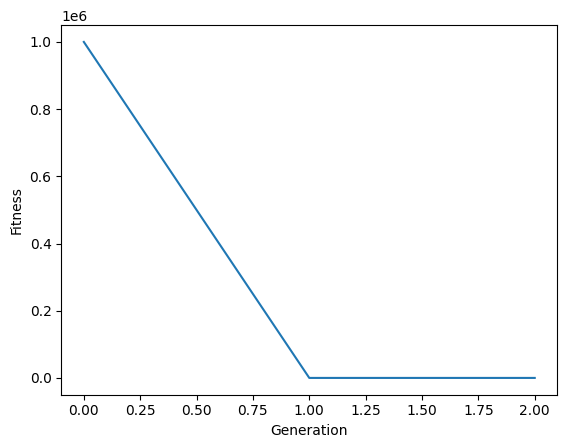

In [107]:

# Genetic Algorithm optimization
best_outputs = []
best_solutions = []  # Store the best solution for each generation
best_fitnesses = []  # Store the best fitness for each generation
new_population = initial_population

for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measuring the fitness of each chromosome in the population.
    fitness_values = []
    delta_IL_percent_values = []
    delta_Vo_percent_values = []
    for individual in new_population:
        fitness_value = calculate_fitness(individual)
        # print('fitness value', fitness_value)
        fitness_values.append(fitness_value)

    fitness = np.array(fitness_values)
    # print('cek fitness', fitness)

    print("Population", new_population)
    best_outputs.append(np.min(fitness))
    print("Best result:", np.min(fitness))

    # Find the index of the best solution in this generation
    best_solution_idx = np.argmin(fitness)
    print("Best solution index:", best_solution_idx)

    # Retrieve the best solution from the population
    best_solution = new_population[best_solution_idx].copy()  # Copy the best solution
    print("Best solution:", best_solution)

    # Append the current best solution to the list of best solutions
    best_solutions.append(best_solution.copy())  # Append a copy of the best solution
    print("Best solutions array:", best_solutions)

    # Append the corresponding fitness value to the list of best fitnesses
    best_fitness = fitness[best_solution_idx][0]
    # best_fitness = fitness[best_solution_idx][0]

    best_fitnesses.append(best_fitness[0])
    print("Best fitness:", best_fitness)
    print("Best fitnesses:", best_fitnesses)



    # Check and enforce constraints
    for i in range(sol_per_pop):
        if not check_constraints(new_population[i]):
            # Regenerate individual until it satisfies the constraints
            while not check_constraints(new_population[i]):
                # Generate all possible values within the specified range with the desired increment
                L_values_all = np.arange(L_range[0], L_range[1] + 1e-6, 1e-6)
                C_values_all = np.arange(C_range[0], C_range[1] + 1e-6, 1e-6)
                t_dt_values_all = np.arange(t_dt_range[0], t_dt_range[1] + 0.001e-6, 0.001e-6)

                    
                # Generate new random values for fsw, L, and C
                new_L = np.random.choice(L_values_all, 1, replace=False)
                new_C = np.random.choice(C_values_all, 1, replace=False)
                new_fsw = np.random.randint(fsw_range[0], fsw_range[1] + 1, size=1)
                new_t_dt = np.random.choice(t_dt_values_all, 1, replace=False)

                new_population[i] = [new_L[0], new_C[0], new_fsw[0], new_t_dt[0]]
                # new_population[i] = generate_feasible_solution(L_range, C_range, fsw_range)

    # max_search_iterations = 100  # Maximum number of iterations to search for feasible solutions
    # search_iterations = 0  # Counter for search iterations
    # shrink_factor = 1 

    # # Initialize current ranges
    # current_L_range = L_range
    # current_C_range = C_range
    # current_fsw_range = fsw_range
    # current_t_dt_range = t_dt_range
    
    # for i in range(sol_per_pop):
    #     search_iterations = 0  # Reset search iterations counter for each individual
    #     while not check_constraints(new_population[i]):
    #         # Regenerate individual within the current ranges
    #         new_L = np.random.uniform(current_L_range[0], current_L_range[1])
    #         new_C = np.random.uniform(current_C_range[0], current_C_range[1])
    #         new_fsw = np.random.randint(current_fsw_range[0], current_fsw_range[1] + 1)
    #         new_t_dt = np.random.uniform(current_t_dt_range[0], current_t_dt_range[1])

    #         new_population[i] = [new_L, new_C, new_fsw, new_t_dt]

    #         search_iterations += 1  # Increment search iterations counter
    #         print("iteration",search_iterations)
    #         # Adjust shrink factor if maximum search iterations exceeded
    #         if search_iterations >= max_search_iterations:
    #             shrink_factor -= 0.05  # Decrease shrink factor
    #             print("shrink factor", shrink_factor)
    #             current_L_range = [L_range[0] * shrink_factor, L_range[1] * shrink_factor]
    #             current_C_range = [C_range[0] * shrink_factor, C_range[1] * shrink_factor]
    #             current_fsw_range = [fsw_range[0] * shrink_factor, fsw_range[1] * shrink_factor]
    #             current_t_dt_range = [t_dt_range[0] * shrink_factor, t_dt_range[1] * shrink_factor]
    #             break  # Exit the loop if maximum search iterations exceeded

    # Print the selected new population that meets the constraints
    print("Selected new population:", new_population)

    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)
    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover_adaptive(parents, offspring_size=(pop_size[0]-parents.shape[0], 4), best_fitnesses=best_fitnesses)
    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    # offspring_mutation = ga.mutation(offspring_crossover, 2)
    # offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, 1)
    offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, t_dt_range, 2)
    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness_values = []

for individual in new_population:
    fitness_value= calculate_fitness(individual)
    fitness_values.append(fitness_value)

fitness = np.array(fitness_values)


# Then return the index of that solution corresponding to the best fitness.
# best_match_idx = np.where(fitness == np.min(fitness))
best_match_idx = np.where(fitness == np.min(fitness))[0]

print("Best solution : ", new_population[best_match_idx, :])
# print("cek")
print("Best solution fitness : ", fitness[best_match_idx])
# print("ceki")

plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

In [ ]:
print(best_fitnesses)

[1000001.56, 5.5495815, 5.5495815, 5.5495815, 5.5495815]


In [ ]:
# Print the best solutions for each generation
print("Best solutions for each generation:")
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    print("Generation", i, ":", "Fitness:", fitness)
    print("Solution (L, C, fsw):", solution)
    
    # Calculate additional information for the current solution
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    t_dt = solution[3]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)
    
    # Prepare input values for prediction
    input_values = np.array([L, C, fs, t_dt])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_scaled[3] = (input_values[3] - t_dt_min) / (t_dt_max - t_dt_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))
    
    # Make predictions using the model
    # prediction = model.predict(input_values_reshaped, verbose=0)
    # print("Prediction: ", prediction)
    # print("Shape: ", prediction.shape)
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    Delta_IL_percent = model_delta_current.predict(input_values_reshaped, verbose=0)
    Delta_Vo_percent = model_delta_voltage.predict(input_values_reshaped, verbose=0)
    Voltage_ori = model_voltage.predict(input_values_reshaped, verbose = 0)

    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent)


    print("Volume L:", Vol_L)
    print("Volume C:", Vol_C)
    print("Delta Vo percent:", Delta_Vo_percent)
    print("Delta Il percent:", Delta_IL_percent)
    print("Voltage:", Voltage)
    print()  # Add a blank line for readability


Best solutions for each generation:
Generation 0 : Fitness: 1000001.56
Solution (L, C, fsw): [2.e-03 2.e-04 2.e+05 1.e-06]
Volume L: 2.0828406321502e-06
Volume C: 6.86e-07
Delta Vo percent: [[6.3104124]]
Delta Il percent: [[15.964979]]
Voltage: [[2.2323923]]

Generation 1 : Fitness: 5.5495815
Solution (L, C, fsw): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo percent: [[0.70585895]]
Delta Il percent: [[6.2308335]]
Voltage: [[10.871354]]

Generation 2 : Fitness: 5.5495815
Solution (L, C, fsw): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo percent: [[0.70585895]]
Delta Il percent: [[6.2308335]]
Voltage: [[10.871354]]

Generation 3 : Fitness: 5.5495815
Solution (L, C, fsw): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo percent: [[0.70585895]]
Delta Il percent: [[6.2308335]]
Voltage: [[10.871354]]

Generation 4 : Fi

## Ranking

Sorted Solutions:
Rank: 1
Solution (L, C, fsw, t_dt): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Fitness: 5.5495815
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo: [[0.70585895]]
Delta IL: [[6.2308335]]
Voltage: [[10.871354]]
P_l_s1:  [[2.0952182]]
P_l_s2:  [[2.0952182]]
P_l_C:  [[0.13386479]]
P_l_L_Cu:  [[1.2015224]]
P_D:  [[0.02375785]]
Losses Total: [[5.5495815]]

Rank: 2
Solution (L, C, fsw, t_dt): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Fitness: 5.5495815
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo: [[0.70585895]]
Delta IL: [[6.2308335]]
Voltage: [[10.871354]]
P_l_s1:  [[2.0952182]]
P_l_s2:  [[2.0952182]]
P_l_C:  [[0.13386479]]
P_l_L_Cu:  [[1.2015224]]
P_D:  [[0.02375785]]
Losses Total: [[5.5495815]]

Rank: 3
Solution (L, C, fsw, t_dt): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Fitness: 5.5495815
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo: [[0.70585895]]
Delta IL: [[6.2308335]]
Voltage: [[10.871354]]
P_l_s1:  [[2.0952182]]
P_

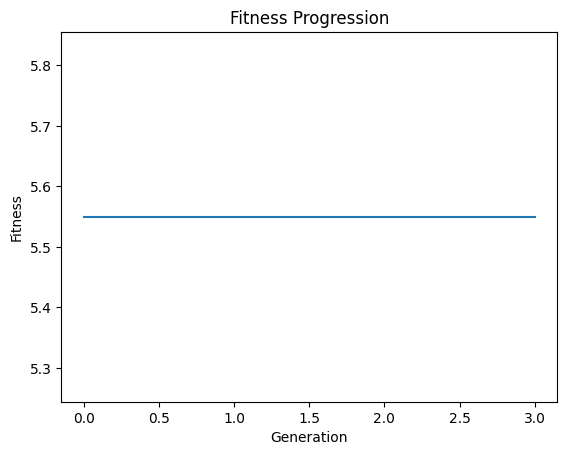

In [ ]:
# Your additional code snippet for printing and sorting the results
# Define lists to store the results
volume_L_values = []
volume_C_values = []
delta_Vo_values = []
delta_IL_values = []
P_l_s1_values = []
P_l_s2_values = []
P_l_C_values = []
P_l_L_Cu_values = []
P_D_values = []
Voltage_values = []
solutions = []

# Iterate over different generations
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    # Calculate volume values and delta Vo for the current solution
    if fitness > 1e6:
        continue
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    t_dt = solution[3]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)

    input_values = np.array([L, C, fs, t_dt])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_scaled[3] = (input_values[3] - t_dt_min) / (t_dt_max - t_dt_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    P_l_s1_ori = model_P_l_s1.predict(input_values_reshaped, verbose=0)
    P_l_s1 = scaler_y_Pl_s1.inverse_transform(P_l_s1_ori)
    P_l_s2 = P_l_s1
    P_l_C = model_P_l_C.predict(input_values_reshaped, verbose=0)
    P_l_L_Cu = model_P_l_L_Cu.predict(input_values_reshaped, verbose=0)
    P_D = model_P_D.predict(input_values_reshaped, verbose=0)
    
    Delta_IL_percent = model_delta_current.predict(input_values_reshaped, verbose = 0)
    Delta_Vo_percent = model_delta_voltage.predict(input_values_reshaped, verbose = 0)
    Voltage_ori = model_voltage.predict(input_values_reshaped, verbose = 0)

    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent)


    # prediction = model.predict(input_values_reshaped, verbose=0)
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    # P_l_s1 = prediction[0][2]
    # P_l_s2 = prediction[0][3]
    # P_l_C = prediction[0][4]
    # P_l_L_Cu = prediction[0][5]
    # P_D = prediction[0][6]
    
    # Store the volume values, delta Vo, and solution for sorting
    volume_L_values.append(Vol_L)
    volume_C_values.append(Vol_C)
    Voltage_values.append(Voltage)
    delta_Vo_values.append(Delta_Vo_percent)
    delta_IL_values.append(Delta_IL_percent)
    P_l_s1_values.append(P_l_s1)
    P_l_s2_values.append(P_l_s2)
    P_l_C_values.append(P_l_C)
    P_l_L_Cu_values.append(P_l_L_Cu)
    P_D_values.append(P_D)

    solutions.append((solution, fitness, Vol_L, Vol_C, Voltage, Delta_Vo_percent, Delta_IL_percent, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu, P_D))

# Sort the solutions based on fitness values in ascending order
sorted_solutions = sorted(solutions, key=lambda x: x[1])

# Print the sorted solutions
print("Sorted Solutions:")
for rank, (solution, fitness, vol_L, vol_C, voltage, delta_Vo, delta_IL, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu, P_D) in enumerate(sorted_solutions):
    print("Rank:", rank + 1)
    print("Solution (L, C, fsw, t_dt):", solution)
    print("Fitness:", fitness)
    print("Volume L:", vol_L)
    print("Volume C:", vol_C)
    print("Delta Vo:", delta_Vo)
    print("Delta IL:", delta_IL)
    print("Voltage:", Voltage)
    print("P_l_s1: ", P_l_s1)
    print("P_l_s2: ", P_l_s2)
    print("P_l_C: ", P_l_C)
    print("P_l_L_Cu: ", P_l_L_Cu)
    print("P_D: ", P_D)
    print("Losses Total:", P_l_s1 + P_l_s2 + P_l_C + P_l_L_Cu + P_D)
    print()

# Plot the fitness values for each generation
# plt.plot(best_outputs)
# plt.xlabel("Generation")
# plt.ylabel("Fitness")
# plt.title("Fitness Progression")
# plt.show()

filtered_best_outputs = [output for output in best_outputs if output <= 1e6]

# Plot the filtered fitness values for each generation
plt.plot(filtered_best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Progression")
plt.show()


## Ranking with constraint

Sorted Solutions:
Rank: 1
Solution (L, C, fsw, t_dt): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Fitness: 5.5495815
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Voltage: [[10.871354]]
Delta Vo: [[0.70585895]]
Delta IL: [[6.2308335]]
P_l_s1:  [[2.0952182]]
P_l_s2:  [[2.0952182]]
P_l_C:  [[0.13386479]]
P_l_L_Cu:  [[1.2015224]]
P_D:  [[0.02375785]]
Losses Total: [[5.5495815]]

Rank: 2
Solution (L, C, fsw, t_dt): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Fitness: 5.5495815
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Voltage: [[10.871354]]
Delta Vo: [[0.70585895]]
Delta IL: [[6.2308335]]
P_l_s1:  [[2.0952182]]
P_l_s2:  [[2.0952182]]
P_l_C:  [[0.13386479]]
P_l_L_Cu:  [[1.2015224]]
P_D:  [[0.02375785]]
Losses Total: [[5.5495815]]

Rank: 3
Solution (L, C, fsw, t_dt): [9.4800e-04 3.0000e-05 5.6411e+04 1.7800e-07]
Fitness: 5.5495815
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Voltage: [[10.871354]]
Delta Vo: [[0.70585895]]
Delta IL: [[6.2308335]]
P_l_s1:  [[2.0952182]]
P_

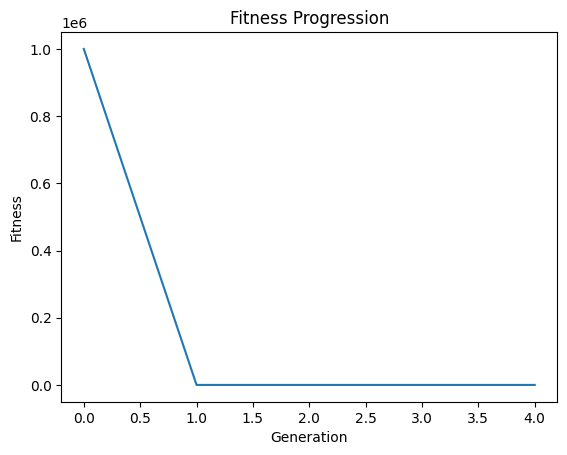

In [ ]:
# Your additional code snippet for printing and sorting the results
# Define lists to store the results
volume_L_values = []
volume_C_values = []
delta_Vo_values = []
delta_IL_values = []
P_l_s1_values = []
P_l_s2_values = []
P_l_C_values = []
P_l_L_Cu_values = []
P_D_values = []
Voltage_values = []
solutions = []

# Iterate over different generations
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    # Calculate volume values and delta Vo for the current solution
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    t_dt = solution[3]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)

    input_values = np.array([L, C, fs, t_dt])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_scaled[3] = (input_values[3] - t_dt_min) / (t_dt_max - t_dt_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    P_l_s1_ori = model_P_l_s1.predict(input_values_reshaped, verbose=0)
    P_l_s1 = scaler_y_Pl_s1.inverse_transform(P_l_s1_ori)
    P_l_s2 = P_l_s1
    P_l_C = model_P_l_C.predict(input_values_reshaped, verbose=0)
    P_l_L_Cu = model_P_l_L_Cu.predict(input_values_reshaped, verbose=0)
    P_D = model_P_D.predict(input_values_reshaped, verbose=0)
    Delta_IL_percent = model_delta_current.predict(input_values_reshaped, verbose = 0)
    Delta_Vo_percent = model_delta_voltage.predict(input_values_reshaped, verbose = 0)
    Voltage_ori = model_voltage.predict(input_values_reshaped, verbose = 0)

    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent)


    # prediction = model.predict(input_values_reshaped, verbose=0)
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    # P_l_s1 = prediction[0][2]
    # P_l_s2 = prediction[0][3]
    # P_l_C = prediction[0][4]
    # P_l_L_Cu = prediction[0][5]
    # P_D = prediction[0][6]

    # Check constraints for the current solution
    if check_constraints(solution):
        # Store the volume values, delta Vo, and solution for sorting
        volume_L_values.append(Vol_L)
        volume_C_values.append(Vol_C)
        Voltage_values.append(Voltage)
        delta_Vo_values.append(Delta_Vo_percent)
        delta_IL_values.append(Delta_IL_percent)
        P_l_s1_values.append(P_l_s1)
        P_l_s2_values.append(P_l_s2)
        P_l_C_values.append(P_l_C)
        P_l_L_Cu_values.append(P_l_L_Cu)
        P_D_values.append(P_D)

        solutions.append((solution, fitness, Vol_L, Vol_C, Voltage, Delta_Vo_percent, Delta_IL_percent, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu, P_D))

# Sort the solutions based on fitness values in ascending order
sorted_solutions = sorted(solutions, key=lambda x: x[1])

# Print the sorted solutions
print("Sorted Solutions:")
for rank, (solution, fitness, vol_L, vol_C, Voltage, delta_Vo, delta_IL, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu, P_D) in enumerate(sorted_solutions):
    print("Rank:", rank + 1)
    print("Solution (L, C, fsw, t_dt):", solution)
    print("Fitness:", fitness)
    print("Volume L:", vol_L)
    print("Volume C:", vol_C)
    print("Voltage:", Voltage)
    print("Delta Vo:", delta_Vo)
    print("Delta IL:", delta_IL)
    print("P_l_s1: ", P_l_s1)
    print("P_l_s2: ", P_l_s2)
    print("P_l_C: ", P_l_C)
    print("P_l_L_Cu: ", P_l_L_Cu)
    print("P_D: ", P_D)
    print("Losses Total:", P_l_s1 + P_l_s2 + P_l_C + P_l_L_Cu + P_D)
    print()

# Plot the fitness values for each generation
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Progression")
plt.show()


# Search Parameters

## Genetic Algorithm

In [ ]:
def generate_initial_population(L_range, C_range, fsw_range, t_dt_range, num_values):
    # Create arrays of discrete L, C, and fsw values within the specified ranges
    L_values = np.linspace(L_range[0], L_range[1], num=num_values)
    C_values = np.linspace(C_range[0], C_range[1], num=num_values)
    t_dt_values = np.linspace(t_dt_range[0], t_dt_range[1], num=num_values)

    # Round the values to the desired number of decimal places
    L_values = np.around(L_values, decimals=6)
    C_values = np.around(C_values, decimals=6)
    t_dt_values = np.around(t_dt_values, decimals=9)

    fsw_values = np.linspace(fsw_range[0], fsw_range[1], num=num_values, dtype=int)

    initial_population = np.column_stack((L_values, C_values, fsw_values, t_dt_values))

    return initial_population

def genetic_algorithm(combinations, num_generations,pop_size):
    for idx, (sol_per_pop, num_parents_mating) in enumerate(combinations):
        print(f"Running combination {idx + 1}/{len(combinations)} with sol_per_pop={sol_per_pop}, num_parents_mating={num_parents_mating}")
        
        best_outputs = []
        best_solutions = []  # Store the best solution for each generation
        best_fitnesses = []  # Store the best fitness for each generation
        initial_population = generate_initial_population(L_range, C_range, fsw_range, t_dt_range, sol_per_pop)
        new_population = initial_population

        for generation in range(num_generations):
            print("Generation : ", generation)
            
            # Measuring the fitness of each chromosome in the population.
            fitness_values = []
            for individual in new_population:
                fitness_value = calculate_fitness(individual)
                fitness_values.append(fitness_value)

            fitness = np.array(fitness_values)

            print("Population", new_population)
            best_outputs.append(np.min(fitness))
            print("Best result:", np.min(fitness))

            best_solution_idx = np.argmin(fitness)
            print("Best solution index:", best_solution_idx)

            best_solution = new_population[best_solution_idx].copy()
            print("Best solution:", best_solution)

            best_solutions.append(best_solution.copy())
            print("Best solutions array:", best_solutions)

            best_fitness = fitness[best_solution_idx][0]
            best_fitnesses.append(best_fitness[0])
            print("Best fitness:", best_fitness)
            print("Best fitnesses:", best_fitnesses)

            for i in range(sol_per_pop):
                if not check_constraints(new_population[i]):
                    while not check_constraints(new_population[i]):
                        # Generate new random values for each parameter
                        new_L = np.random.uniform(*L_range)
                        new_C = np.random.uniform(*C_range)
                        new_fsw = np.random.randint(*fsw_range)
                        new_t_dt = np.random.uniform(*t_dt_range)
                        new_population[i] = [new_L, new_C, new_fsw, new_t_dt]

            parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)
            print("Parent:\n",parents)
            offspring_crossover = ga.crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], 4))
            print("Crossover:\n", offspring_crossover)
            offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, t_dt_range, 2)
            print("Mutation:\n", offspring_mutation)
            new_population[0:parents.shape[0], :] = parents
            if offspring_mutation.shape[0] > 0:
                new_population[parents.shape[0]:parents.shape[0]+offspring_mutation.shape[0], :] = offspring_mutation
        fitness_values = []

        for individual in new_population:
            fitness_value= calculate_fitness(individual)
            fitness_values.append(fitness_value)

        fitness = np.array(fitness_values)

        best_match_idx = np.where(fitness == np.min(fitness))[0]

        print("Best solution : ", new_population[best_match_idx, :])
        print("Best solution fitness : ", fitness[best_match_idx])

        plt.plot(best_outputs)
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these functions and variables are defined somewhere else in your code
# calculate_fitness, check_constraints, ga.select_mating_pool, ga.crossover, ga.mutation



# Define your ranges and other parameters
L_range = [30e-6, 2000e-6]
C_range = [30e-6, 200e-6]
fsw_range = [20e3, 200e3]
t_dt_range = [0.178e-6, 1e-6]


num_generations = 5  # Example number of generations

# Define the combinations of parameters you want to try
combinations = [
    (10, 2),
    (20, 4),

    (30, 15)
]
    # (30, 6),

for sol_per_pop, num_parents_mating in combinations:
    pop_size = (sol_per_pop, 4)
    genetic_algorithm(combinations, num_generations, pop_size)


Running combination 1/3 with sol_per_pop=10, num_parents_mating=2
Generation :  0
Population [[3.000e-05 3.000e-05 2.000e+04 1.780e-07]
 [2.490e-04 4.900e-05 4.000e+04 2.690e-07]
 [4.680e-04 6.800e-05 6.000e+04 3.610e-07]
 [6.870e-04 8.700e-05 8.000e+04 4.520e-07]
 [9.060e-04 1.060e-04 1.000e+05 5.430e-07]
 [1.124e-03 1.240e-04 1.200e+05 6.350e-07]
 [1.343e-03 1.430e-04 1.400e+05 7.260e-07]
 [1.562e-03 1.620e-04 1.600e+05 8.170e-07]
 [1.781e-03 1.810e-04 1.800e+05 9.090e-07]
 [2.000e-03 2.000e-04 2.000e+05 1.000e-06]]
Best result: 1000001.56
Best solution index: 9
Best solution: [2.e-03 2.e-04 2.e+05 1.e-06]
Best solutions array: [array([2.e-03, 2.e-04, 2.e+05, 1.e-06])]
Best fitness: [1000001.56]
Best fitnesses: [1000001.56]


In [70]:
import numpy as np

def calculate_crossover_point(parents):
    # Calculate crossover point based on some heuristic or default value
    return int(parents.shape[1] / 2)

def calculate_diversity(parents):
    # Calculate diversity of the population (e.g., based on distance between individuals)
    # This is just a placeholder, you should replace it with a meaningful diversity measure
    return np.random.rand()

def adapt_crossover_point(crossover_point):
    # Adapt the crossover point based on some adaptive mechanism
    # For simplicity, let's just increment the crossover point by 1
    return crossover_point + 1

def adaptive_crossover(parents, offspring_size, diversity_threshold):
    offspring = np.empty(offspring_size)
    crossover_point = calculate_crossover_point(parents)
    
    # Check diversity and adapt crossover point if needed
    if calculate_diversity(parents) < diversity_threshold:
        crossover_point = adapt_crossover_point(crossover_point)
    
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    
    return offspring

# Example parameters

 # Number of offspring and chromosome length
diversity_threshold = 0.5  # Example diversity threshold

# Perform adaptive crossover
offspring = adaptive_crossover(parents, offspring_size, diversity_threshold)
print("Offspring after adaptive crossover:")
print(offspring)


Offspring after adaptive crossover:
[[10.  9.  8.  0.]
 [ 3.  2.  1.  4.]
 [ 1.  2.  3.  7.]
 [10.  9.  8.  0.]
 [ 3.  2.  1.  4.]]


In [68]:
def detect_stagnation(best_fitnesses, num_generations, stagnation_threshold):
    if num_generations < stagnation_threshold:
        return False  # Not enough generations to detect stagnation
    
    # Check if best fitness values have remained unchanged for stagnation_threshold generations
    for i in range(num_generations - stagnation_threshold, num_generations - 1):
        if best_fitnesses[i] != best_fitnesses[i+1]:
            return False  # Fitness values have changed, not stagnating
    
    return True  # Stagnation detected

# Example usage:
best_fitnesses = [100, 90, 85, 85, 85, 0]  # Example best fitness values over generations
num_generations = len(best_fitnesses)
stagnation_threshold = 3  # Number of consecutive generations to consider for stagnation detection

if detect_stagnation(best_fitnesses, num_generations, stagnation_threshold):
    print("Stagnation detected!")
else:
    print("No stagnation detected.")


No stagnation detected.


In [124]:
def adaptive_crossover(parents, offspring_size,best_fitnesses):
    offspring = np.empty(offspring_size)
    crossover_point = calculate_crossover_point(parents)
    
    # Check if stagnation is detected and adapt crossover accordingly
    if detect_stagnation(best_fitnesses):
        # Apply adaptive crossover strategy
        crossover_point = adapt_crossover_point_for_stagnation(crossover_point)
    
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    
    return offspring


def adapt_crossover_point_for_stagnation(crossover_point):
    # Modify crossover point for adaptive crossover during stagnation
    # Example: Increment the crossover point by a fixed amount
    return 3

def detect_stagnation(best_fitnesses, stagnation_threshold=3):
    if len(best_fitnesses) < stagnation_threshold:
        return False
    
    # Check if best fitness values have remained unchanged for stagnation_threshold generations
    return all(best_fitnesses[i] == best_fitnesses[i+1] for i in range(len(best_fitnesses) - stagnation_threshold, len(best_fitnesses) - 1))


def crossover(parents, offspring_size, best_fitnesses, stagnation_threshold=3):
    offspring = np.empty(offspring_size)
    
    stagnation = detect_stagnation(best_fitnesses, stagnation_threshold)
    
    if stagnation:
        # Randomly select crossover point between 1 and 3
        crossover_point = np.random.randint(1, offspring_size[1])
        # crossover_point = 3
    else:
        # Use default crossover point (halfway)
        crossover_point = offspring_size[1] // 2

    print("Crossover point:", crossover_point)
    
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    
    return offspring


parents = np.array([[10, 9, 8, 7], [3, 2, 1, 0], [1, 2, 3, 4]])
print("Parents", parents)
offspring_size = (5, 4) 

# Example usage within your genetic algorithm framework
stagnation_threshold = 3  # Number of consecutive generations to consider for stagnation detection
best_fitnesses = [100, 90, 85, 85, 85, 85]  # Example best fitness values over generations
# offspring_adaption = adaptive_crossover(parents, offspring_size, best_fitnesses)
# print("Offspring after adaptive crossover:")
# print(offspring_adaption)



sol_per_pop = 8
num_parents_mating = 4
pop_size = (sol_per_pop, 4)
offspring_crossover = crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], 4), best_fitnesses=best_fitnesses)
print("Offspring ori add:")
print(offspring_crossover)

offspring_crossover_ori = ga.crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], 4))
print("Offspring ori:")
print(offspring_crossover_ori)



Parents [[10  9  8  7]
 [ 3  2  1  0]
 [ 1  2  3  4]]
Crossover point: 3
Offspring ori add:
[[10.  9.  8.  0.]
 [ 3.  2.  1.  4.]
 [ 1.  2.  3.  7.]
 [10.  9.  8.  0.]
 [ 3.  2.  1.  4.]]
Offspring ori:
[[10.  9.  1.  0.]
 [ 3.  2.  3.  4.]
 [ 1.  2.  8.  7.]
 [10.  9.  1.  0.]
 [ 3.  2.  3.  4.]]


# Cari values

In [25]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Define the constraint function
@use_named_args([
    Real(*feature_ranges['L'], name='L'),
    Real(*feature_ranges['C'], name='C'),
    Real(*feature_ranges['fsw'], name='fsw'),
    Real(*feature_ranges['t_dt'], name='t_dt')
])
# def constraint_function(L, C, fsw, t_dt):
#     # Your constraint function goes here
#     # Return True if the combination satisfies the constraint, False otherwise
#     # For example, if your constraint function is a simple check, you can return True if satisfied, False otherwise
#     return constraint_satisfied(L, C, fsw, t_dt)

def constraint_function(L, C, fsw, t_dt):
    L = L
    C = C
    fs = fsw
    t_dt = t_dt
    
    # Define the constraint values
    nearest_C, Vol_C  = search_volume_capacitance(C, csv_file_capacitance) # Define Vol_L based on your problem-specific requirements
    nearest_L, Vol_L  = search_volume_inductance(L, csv_file_inductance)

    # Prepare input values for prediction

    input_values = np.array([L, C, fs, t_dt])
    # Apply Min-Max normalization separately for each input feature
    
    # print("input_values", input_values)
    input_values_scaled = scale_input_values(input_values)
    # input_values_scaled = scaler_y_new_20_20_20_20.transform(input_values)
    # print("scaled", input_values_scaled)
    # prediction = model.predict(input_values_scaled, verbose = 0)

    # Extract predictions from the model output
    Delta_IL_percent_ori = model_delta_current.predict(input_values_scaled, verbose = 0)
    Delta_Vo_percent_ori = model_delta_voltage.predict(input_values_scaled, verbose = 0)

    Voltage_ori = model_voltage.predict(input_values_scaled, verbose = 0)
    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    # Voltage = 12
    # print("Voltage:", Voltage)

    
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    # print("Shape \n")
    # print(Delta_IL_percent_ori.shape)
    # print(Delta_Vo_percent_ori.shape)
    # scaler_y_new_loaded = load(r'E:\ai-power-converter\machine-learning\scaler_y_new_20_20_20_20.joblib')
    
    # # Fit the scaler with the training data
    # scaler_y_new_loaded.fit([[feature_min], [feature_max]])
    # Inverse transform the predictions
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent_ori)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent_ori)

    # print("delta_IL inverse",Delta_IL_percent)
    # print("delta_Vo inverse",Delta_Vo_percent)

    # Delta_IL_percent = inverse_scale_input_values(Delta_IL_percent_ori)
    # Delta_Vo_percent = inverse_scale_input_values(Delta_Vo_percent_ori)

    # Define the acceptable voltage range
    acceptable_voltage_range = (V_out - Voltage_percent_lim * V_out, V_out + Voltage_percent_lim * V_out)

    # Check if Voltage_ori is within the acceptable voltage range


    # Check if constraints are satisfied
    constraint1 = Vol_C + Vol_L  <= Vol_lim
    constraint2 = Delta_Vo_percent <= Delta_Vo_percent_lim
    constraint3 = Delta_IL_percent <= Delta_IL_percent_lim
    constraint4 = (Voltage >= acceptable_voltage_range[0]) and (Voltage <= acceptable_voltage_range[1])
    
    # print("Constraint 1", constraint1)
    # print("Constraint 2", constraint2)
    # print("Constraint 3", constraint3)
    # print("Constraint 4", constraint4)

    # print("Constraint:", constraint1 and constraint2 and constraint3 and constraint4)

    # return constraint1 and constraint2 and constraint3
    degree_of_satisfaction = 0
    if not constraint1:
        degree_of_satisfaction += 1
    if not constraint2:
        degree_of_satisfaction += 1
    if not constraint3:
        degree_of_satisfaction += 1
    if not constraint4:
        degree_of_satisfaction += 1
    return degree_of_satisfaction 

# Perform Bayesian optimization
result = gp_minimize(constraint_function, 
                     [(30e-6, 2000e-6), (20e-6, 1000e-6), (20e3, 200e3), (0.178e-6, 1e-6)],
                     n_calls=200, 
                     random_state=42,
                     verbose= True)

best_parameters = result.x_iters
satisfactory_parameters = []
for parameters in best_parameters:
    if constraint_function(parameters) == 0:
        satisfactory_parameters.append(parameters)
        print("Parameter combination that satisfies all constraints:", parameters)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0953
Function value obtained: 3.0000
Current minimum: 3.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0929
Function value obtained: 2.0000
Current minimum: 2.0000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0956
Function value obtained: 3.0000
Current minimum: 2.0000
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0957
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0923
Function value obtained: 2.0000
Current minimum: 1.0000
Iteration No: 6 started. Evaluating